In [34]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

1. Load and Inspect Dataset

In [35]:
import pandas as pd

# Load the dataset
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/exercise_employee_attrition.csv"
df = pd.read_csv(url)

# --- Inspection ---
print("--- Initial Dataset Info ---")
df.info()
print(df.head())
print("\nMissing Values Check:", df.isnull().sum().any())

# --- Drop Columns (with a check first) ---
cols_to_drop = ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
# Find which of the columns to drop actually exist in the dataframe
existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]

if existing_cols_to_drop:
    df_processed = df.drop(columns=existing_cols_to_drop)
    print(f"\nDropped the following columns: {existing_cols_to_drop}")
    print("New shape:", df_processed.shape)
else:
    df_processed = df.copy()
    print("\nNo columns needed to be dropped.")

--- Initial Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Employee_ID                    1000 non-null   int64 
 1   Age                            1000 non-null   int64 
 2   Gender                         1000 non-null   object
 3   Marital_Status                 1000 non-null   object
 4   Department                     1000 non-null   object
 5   Job_Role                       1000 non-null   object
 6   Job_Level                      1000 non-null   int64 
 7   Monthly_Income                 1000 non-null   int64 
 8   Hourly_Rate                    1000 non-null   int64 
 9   Years_at_Company               1000 non-null   int64 
 10  Years_in_Current_Role          1000 non-null   int64 
 11  Years_Since_Last_Promotion     1000 non-null   int64 
 12  Work_Life_Balance              100

2. Encode Categorical Features

In [36]:
from sklearn.preprocessing import OrdinalEncoder

# Make a copy for encoding
df_encoded = df_processed.copy()

# --- Manually map known binary columns for clarity ---
# This ensures 'Yes' is always 1 and 'No' is always 0, etc.
binary_maps = {
    'Attrition': {'No': 0, 'Yes': 1},
    'Gender': {'Female': 0, 'Male': 1},
    'OverTime': {'No': 0, 'Yes': 1}
}

for col, mapping in binary_maps.items():
    if col in df_encoded.columns:
        df_encoded[col] = df_encoded[col].map(mapping)

# --- Automatically find and encode all remaining text columns ---
# This is the robust part that doesn't need specific column names
remaining_object_cols = df_encoded.select_dtypes(include=['object']).columns

if not remaining_object_cols.empty:
    encoder = OrdinalEncoder()
    df_encoded[remaining_object_cols] = encoder.fit_transform(df_encoded[remaining_object_cols])


# --- Verification ---
print("\n--- Encoding Complete ---")
print("All columns have been converted to integer types:")
df_encoded.info()

print("\n--- First 5 Rows of Fully Encoded Data ---")
print(df_encoded.head())


--- Encoding Complete ---
All columns have been converted to integer types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Employee_ID                    1000 non-null   int64  
 1   Age                            1000 non-null   int64  
 2   Gender                         1000 non-null   int64  
 3   Marital_Status                 1000 non-null   float64
 4   Department                     1000 non-null   float64
 5   Job_Role                       1000 non-null   float64
 6   Job_Level                      1000 non-null   int64  
 7   Monthly_Income                 1000 non-null   int64  
 8   Hourly_Rate                    1000 non-null   int64  
 9   Years_at_Company               1000 non-null   int64  
 10  Years_in_Current_Role          1000 non-null   int64  
 11  Years_Since_Last_Promotion     1

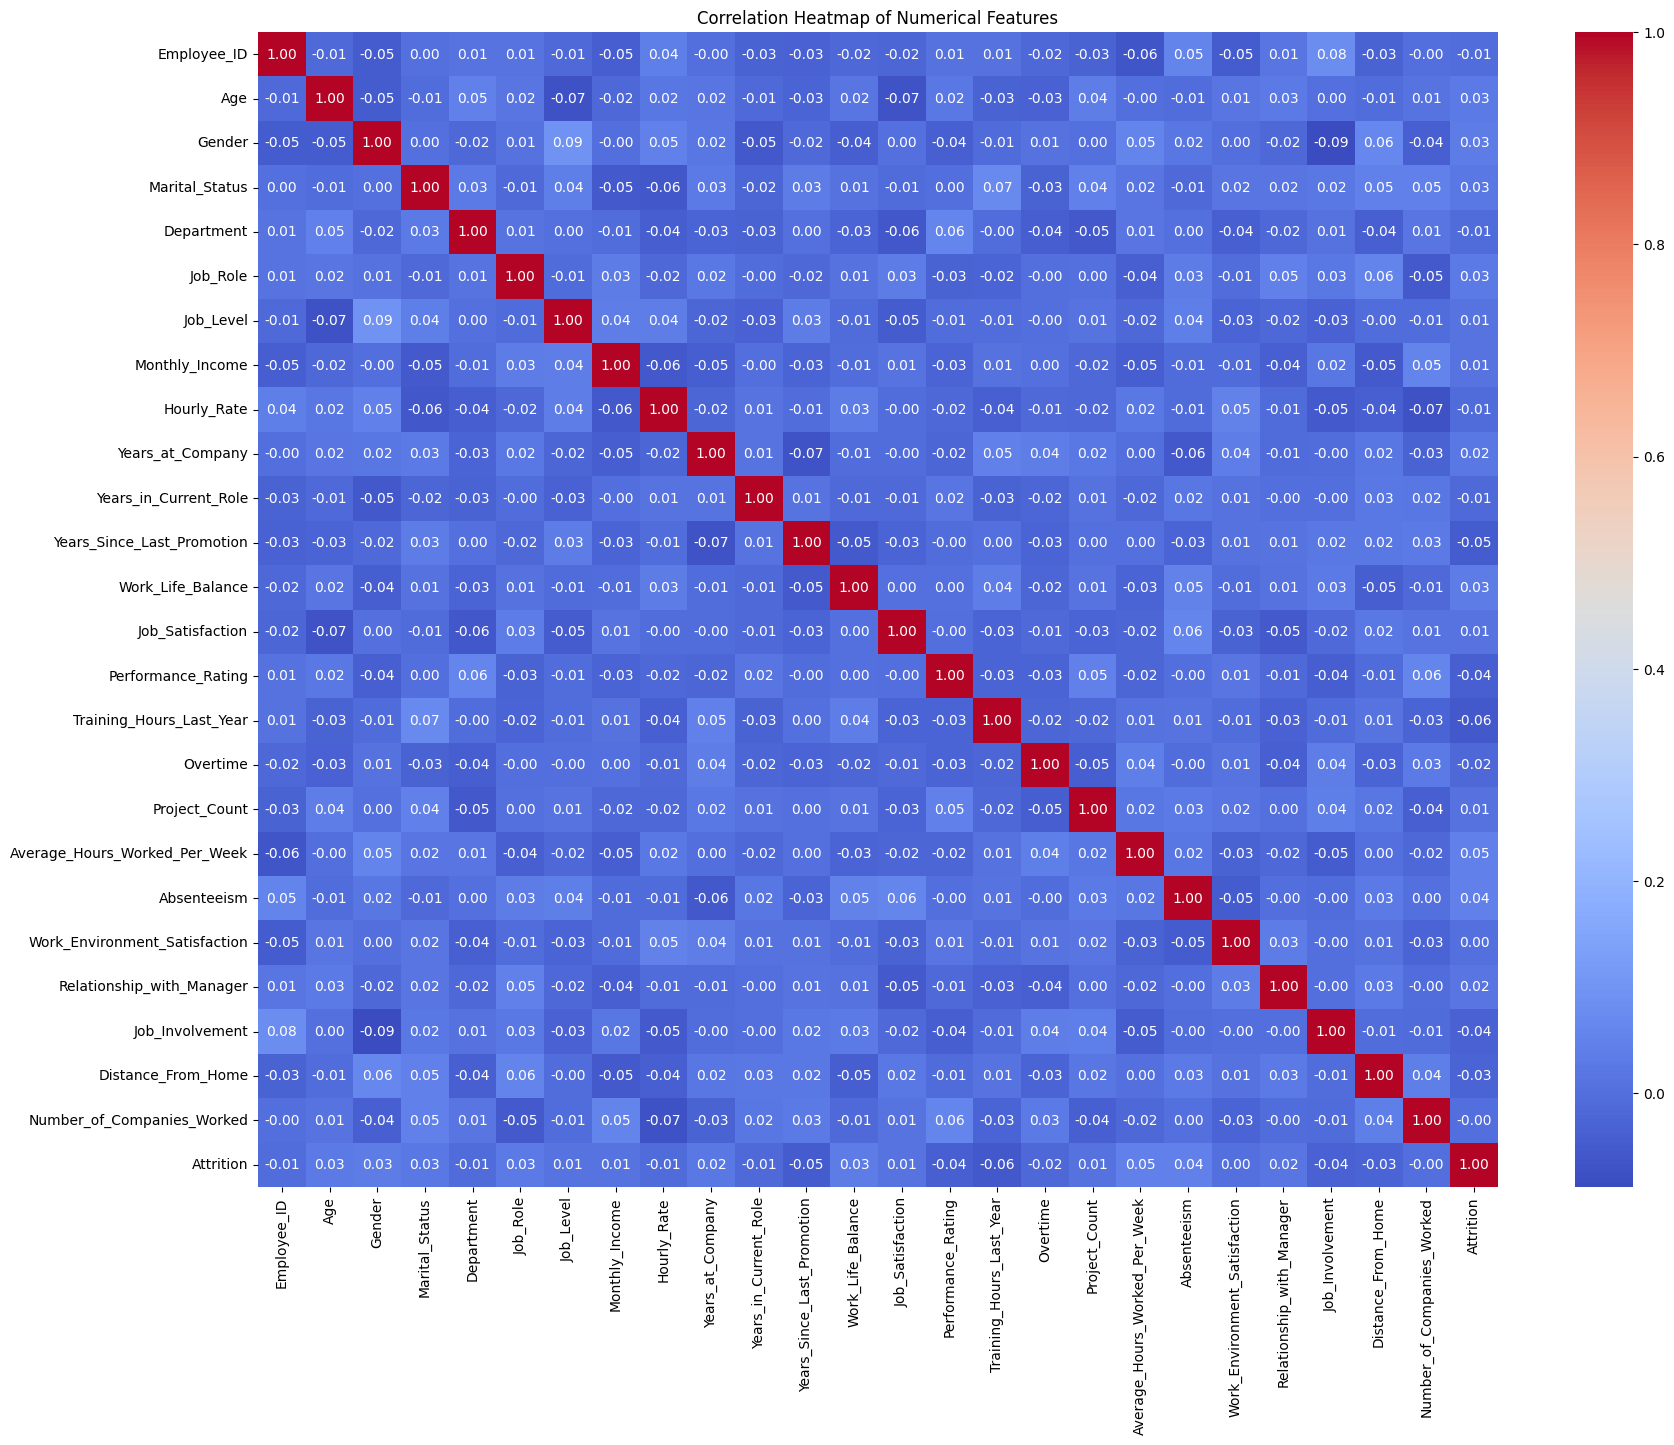

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Generate and Display the Heatmap ---

# 1. Select only numerical columns for the correlation matrix
numerical_df = df_encoded.select_dtypes(include=['int64', 'float64'])

# 2. Calculate the correlation matrix
corr_matrix = numerical_df.corr()

# 3. Create the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

3. Partition Data into Training and Testing Sets

In [38]:
from sklearn.model_selection import train_test_split

X = df_encoded[['Years_Since_Last_Promotion', 'Performance_Rating', 'Training_Hours_Last_Year', 'Average_Hours_Worked_Per_Week', 'Absenteeism', 'Job_Involvement']]
y = df_encoded['Attrition']

# Split data: 80% training, 20% testing, stratified to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (800, 6)
Testing set shape: (200, 6)


4. Decision Tree (Model Development)

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

baseline_model = DecisionTreeClassifier(random_state=42)
baseline_model.fit(X_train, y_train)

print("\n--- Baseline Model Performance (Test Set) ---")
y_pred_baseline = baseline_model.predict(X_test)
print(classification_report(y_test, y_pred_baseline))


--- Baseline Model Performance (Test Set) ---
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       162
           1       0.20      0.29      0.23        38

    accuracy                           0.64       200
   macro avg       0.50      0.51      0.50       200
weighted avg       0.70      0.64      0.66       200



5. Handle Class Imbalance and Tune Hyperparameters

In [40]:
# Import necessary libraries for this step
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("--- Class Imbalance Handled using SMOTE ---")
print("Resampled data distribution:\n", y_train_resampled.value_counts())


# --- Hyperparameter Tuning ---
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 7, 9, 11],  # Test specific, limited depths
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6] # Start min_samples_leaf from 2 to avoid nodes with single samples
}

# The rest of your GridSearchCV code remains the same
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1',
                           n_jobs=-1)

grid_search.fit(X_train_resampled, y_train_resampled)
best_model = grid_search.best_estimator_

print("\n--- Hyperparameter Tuning Complete (Anti-Overfitting) ---")
print("Best Parameters Found:", grid_search.best_params_)

--- Class Imbalance Handled using SMOTE ---
Resampled data distribution:
 Attrition
0    649
1    649
Name: count, dtype: int64

--- Hyperparameter Tuning Complete (Anti-Overfitting) ---
Best Parameters Found: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 10}


6. Evaluate The Final Tuned Model

--- 1. Baseline Decision Tree Performance (Test Set) ---
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       162
           1       0.20      0.29      0.23        38

    accuracy                           0.64       200
   macro avg       0.50      0.51      0.50       200
weighted avg       0.70      0.64      0.66       200


--- 2. Performance After Applying SMOTE (Test Set) ---
              precision    recall  f1-score   support

           0       0.80      0.62      0.70       162
           1       0.18      0.34      0.23        38

    accuracy                           0.57       200
   macro avg       0.49      0.48      0.47       200
weighted avg       0.68      0.57      0.61       200


--- 3. Final Tuned Model Performance (Test Set) ---
              precision    recall  f1-score   support

           0       0.82      0.65      0.73       162
           1       0.21      0.39      0.28        38

    accuracy    

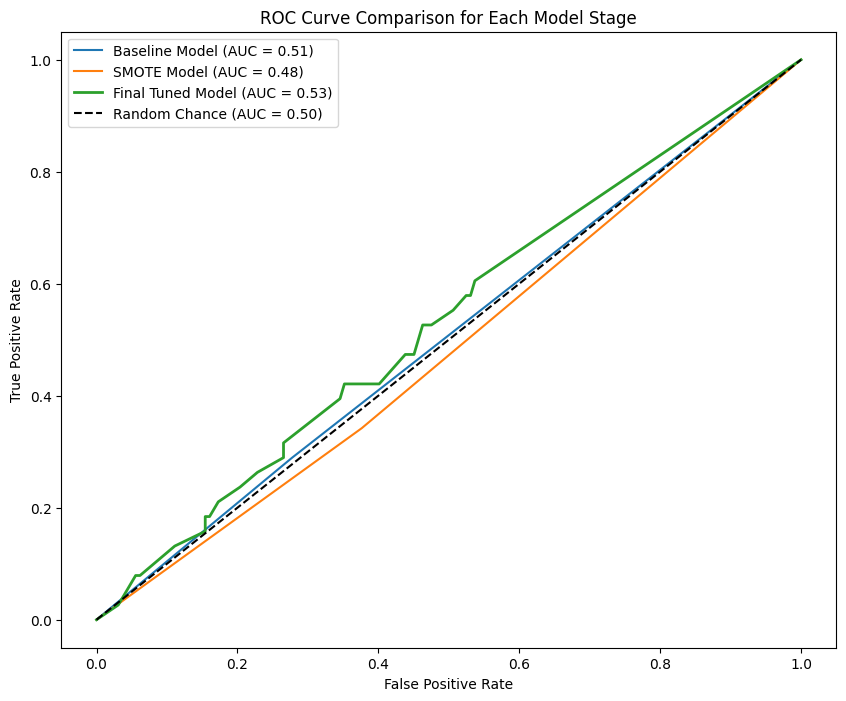

In [41]:
# Import necessary libraries for this step
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# We assume X_train, X_test, y_train, y_test, and the 'best_model' from GridSearchCV are already defined from previous steps.


# 1. BASELINE DECISION TREE (trained on original, imbalanced data)
print("--- 1. Baseline Decision Tree Performance (Test Set) ---")
baseline_model = DecisionTreeClassifier(random_state=42)
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)
print(classification_report(y_test, y_pred_baseline))

# Get probabilities for ROC curve
y_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba_baseline)
auc_base = roc_auc_score(y_test, y_proba_baseline)


# 2. DECISION TREE WITH SMOTE (trained on balanced data, default parameters)

print("\n--- 2. Performance After Applying SMOTE (Test Set) ---")
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train a new Decision Tree on the balanced data
smote_model = DecisionTreeClassifier(random_state=42)
smote_model.fit(X_train_resampled, y_train_resampled)

# Evaluate this model
y_pred_smote = smote_model.predict(X_test)
print(classification_report(y_test, y_pred_smote))

# Get probabilities for ROC curve
y_proba_smote = smote_model.predict_proba(X_test)[:, 1]
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_proba_smote)
auc_smote = roc_auc_score(y_test, y_proba_smote)



# 3. FINAL TUNED MODEL (trained on balanced data with best hyperparameters)

print("\n--- 3. Final Tuned Model Performance (Test Set) ---")
# 'best_model' is the final model from the GridSearchCV step (Step 4)
y_pred_tuned = best_model.predict(X_test)
print(classification_report(y_test, y_pred_tuned))

# Get probabilities for ROC curve
y_proba_tuned = best_model.predict_proba(X_test)[:, 1]
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_proba_tuned)
auc_tuned = roc_auc_score(y_test, y_proba_tuned)

# 4. COMBINED ROC CURVE PLOT

plt.figure(figsize=(10, 8))

# Plot Baseline ROC
plt.plot(fpr_base, tpr_base, label=f'Baseline Model (AUC = {auc_base:.2f})')

# Plot SMOTE-only ROC
plt.plot(fpr_smote, tpr_smote, label=f'SMOTE Model (AUC = {auc_smote:.2f})')

# Plot Final Tuned ROC
plt.plot(fpr_tuned, tpr_tuned, label=f'Final Tuned Model (AUC = {auc_tuned:.2f})', linewidth=2)

# Plotting the diagonal line (random chance)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Each Model Stage')
plt.legend()
plt.show()